In [1]:
import pandas as pd
import joblib
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [3]:
def split_data(df, text_column, target_column, test_size=0.2, random_state=42):
    X = df[text_column]
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
def train_with_grid_search(df, text_column, target_column):
    """Entraîne un modèle avec GridSearchCV et renvoie le meilleur modèle."""
    X = df[text_column]
    y = df[target_column]

    # Séparer les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Définir un pipeline avec TfidfVectorizer et BernoulliNB
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),  # Vectorisation avec TfidfVectorizer
        ('classifier', BernoulliNB())       # Classificateur Bernoulli Naive Bayes
    ])

    # Grille d'hyperparamètres à tester
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Test des unigrammes, bigrammes, trigrammes
        'vectorizer__max_df': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],               # Filtrage par fréquence maximale
        'vectorizer__min_df': [1, 5, 10, 15, 20],                     # Filtrage par fréquence minimale
        'vectorizer__max_features': [None, 500, 1000],         # Limite du nombre de mots
        'classifier__alpha': [0.1, 1, 10]                     # Hyperparamètre alpha de BernoulliNB
    }

    # Configuration de GridSearchCV pour tester les différentes combinaisons de paramètres
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

    # Entraîner le modèle
    grid_search.fit(X_train, y_train)

    return grid_search, X_test, y_test

In [5]:
def save_model(model, model_path='model/bernoulli_model.joblib'):
    """Sauvegarde le modèle."""
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print(f'Modèle sauvegardé sous : {model_path}')

In [6]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=["Négatif", "Positif"])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

In [7]:
def load_model(model_path='model/bernoulli_model.joblib'):
    """Charge le modèle sauvegardé."""
    model = joblib.load(model_path)
    return model

In [8]:
def evaluate_model(model, X_test, y_test):
    """Évalue le modèle et affiche les courbes ROC et précision-rappel ainsi que la matrice de confusion."""
    y_pred = model.predict(X_test)

    # Mapper les étiquettes pour avoir uniquement 'Positif' ou 'Négatif'
    y_test_mapped = map_labels(y_test)
    y_pred_mapped = map_labels(y_pred)

    print(classification_report(y_test_mapped, y_pred_mapped, target_names=["Négatif", "Positif"]))

    # Tracer la matrice de confusion
    plot_confusion_matrix(y_test_mapped, y_pred_mapped)

    return y_pred_mapped, y_test_mapped


In [9]:
def cross_validate_model(model, X_train, y_train):
    """Effectue la validation croisée sur les données d'entraînement."""
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'Cross-validation scores: {scores}')
    print(f'Average cross-validation score: {scores.mean()}')

In [10]:
def convert_prediction_to_sentiment(pred):
    if pred in [0, 1]:
        return "Négatif"
    elif pred in [3, 4]:
        return "Positif"
    else:
        return "Inconnu"  # Ajouter une gestion des valeurs inattendues

In [11]:
def map_labels(labels):
    return ['Négatif' if label in [0, 1] else 'Positif' for label in labels]

In [12]:
def predict_new_text(model, text):
    # Si le modèle est un pipeline, il gère déjà la vectorisation
    # Vous pouvez directement passer le texte brut
    prediction = model.predict([text])

    # Extraire la prédiction comme un entier
    #prediction = int(prediction[0])

    # Utiliser la fonction de mapping déjà définie
    sentiment = convert_prediction_to_sentiment(prediction)

    return prediction, sentiment


In [13]:
def main(file_path, new_text=None):
    """Pipeline principal."""
    # 1. Charger les données
    df = load_data(file_path)

    # 2. Entraîner le modèle
    model, X_test, y_test = train_with_grid_search(df, 'lemmatized_tokens', 'Sentiment')

    # Validation croisée sur l'ensemble d'entraînement
    print("Starting cross-validation...")
    X_train, _, y_train, _ = split_data(df, 'lemmatized_tokens', 'Sentiment')
    cross_validate_model(model.best_estimator_, X_train, y_train)

    # Sauvegarder le modèle
    save_model(model.best_estimator_)

    # 3. Évaluer le modèle
    y_pred, y_test_mapped = evaluate_model(model, X_test, y_test)

    # 4. Prédiction pour un nouveau texte si fourni
    if new_text:
        prediction, sentiment = predict_new_text(model.best_estimator_, new_text)
        print(f"Prédiction pour : '{new_text}' : {sentiment}")

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Starting cross-validation...
Cross-validation scores: [0.46089385 0.47579143 0.44227188 0.45810056 0.46318733]
Average cross-validation score: 0.4600490106750943
Modèle sauvegardé sous : model/bernoulli_model.joblib
              precision    recall  f1-score   support

     Négatif       0.72      0.73      0.73       624
     Positif       0.76      0.76      0.76       719

    accuracy                           0.74      1343
   macro avg       0.74      0.74      0.74      1343
weighted avg       0.74      0.74      0.74      1343



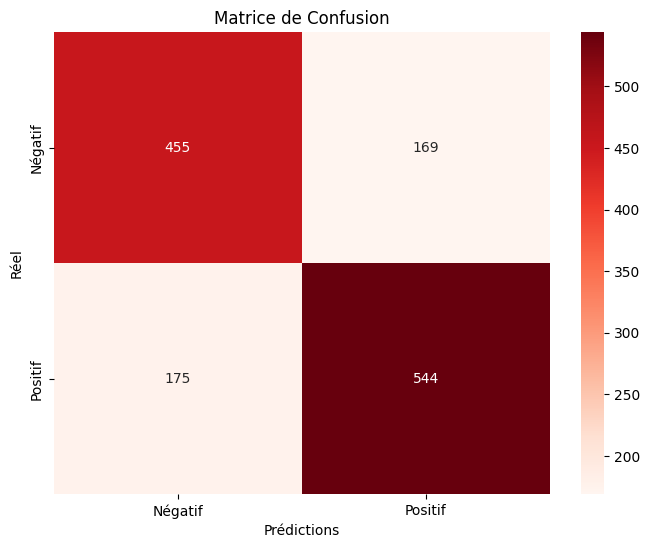

Prédiction pour : 'The film was painfully slow and predictable, with no engaging moments to keep the audience interested.' : Négatif


In [14]:
# Appelle la fonction principale avec le chemin vers ton fichier CSV et un texte à prédire
file_path = 'df_clean_filtered.csv'
new_text = "The film was painfully slow and predictable, with no engaging moments to keep the audience interested."
main(file_path, new_text=new_text)


Fitting 5 folds for each of 810 candidates, totalling 4050 fits


/home/louve/.pyenv/versions/sentiment_analysis/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Starting cross-validation...
Cross-validation scores: [0.46089385 0.47579143 0.44227188 0.45810056 0.46318733]
Average cross-validation score: 0.4600490106750943
Modèle sauvegardé sous : model/bernoulli_model.joblib
              precision    recall  f1-score   support

     Négatif       0.72      0.73      0.73       624
     Positif       0.76      0.76      0.76       719

    accuracy                           0.74      1343
   macro avg       0.74      0.74      0.74      1343
weighted avg       0.74      0.74      0.74      1343



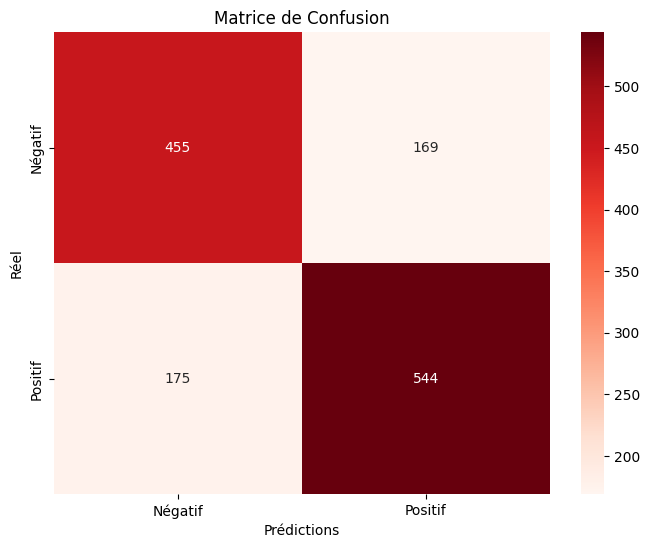

Prédiction pour : 'The movie was absolutely brilliant, with a captivating story, stunning visuals, and outstanding performances from the entire cast!' : Positif


In [15]:
# Appelle la fonction principale avec le chemin vers ton fichier CSV et un texte à prédire
file_path = 'df_clean_filtered.csv'
new_text = "The movie was absolutely brilliant, with a captivating story, stunning visuals, and outstanding performances from the entire cast!"
main(file_path, new_text=new_text)